## About this file
this file helps visualization of allocation results. 

There are two types of plots provided:
- `allocation_plot` plots the allocation provided by a specific method of a given country (compare across different gamma)
- `comparison_plot` plots the allocation provided by different methods of a given country (compare across methods)

Since the functions take in quite a lot of variables, it is advised to input variables using dictionary as you will notice in the sections below.

The plot functions takes around 10s to finish since there are a large number of bars to plot.

In [55]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from utils import load_data
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import time
from utils_db_upload import mdict

### infrastructures

In [56]:
# time series as x-axis, tough issue.. matplotlib go to hell...
def cal_jensen(X, Y):
    """
    calculate Jensen's alpha for a return series. 
    Y denotes the return series and X is the excess market return
    returns Jensen's alpha and its p-value
    """
    import statsmodels.api as sm
    X = pd.DataFrame(X)
    X['const']=1
    res = sm.OLS(Y, X).fit()
    alpha_p = res.pvalues['const']
    alpha = res.params['const']
    return alpha, alpha_p

In [69]:
def cal_perf(code, level, method, show_table = False):
    """
    calculate performance statistics of a method used for a certain market (code)
    code is the country code
    when show_table = True, the function prints a HTML table to the console
    """
    ret_ls = pd.read_csv(rf".\performances\{code}_{level}_{method}.csv", index_col = 0)
    ret_ls = ret_ls.dropna(how='any')
    
    factor_suffix = {'hk':'400', 'cn':'800', 'us':'1500'}
    factor_code = code + factor_suffix[code]
    mkt_ls = pd.read_csv(rf".\input\factor\ten_factor_vw_{factor_code}_week_5.csv", index_col=0)
    
    mkt_ls = mkt_ls[['exmkt','rf']]
    ret_ls = ret_ls.join(mkt_ls)
    name = ret_ls.columns[1]
    values = ret_ls.iloc[:,1].unique()
    periods = 52
    df = {}
    import scipy.stats
    for i, pv in enumerate(values):
        _ret_ls = ret_ls.loc[ret_ls[name] == pv]
        Y = _ret_ls.iloc[:,0]
        X = _ret_ls["exmkt"]
        avg_return = Y.mean()
        cum_return = (Y + 1).prod() - 1
        annual_ex_return = (Y + 1).prod() ** (periods / len(Y)) - 1
        annual_vol = Y.std() * np.sqrt(periods)
        annual_sharpe = annual_ex_return / annual_vol if cum_return > 0 else np.nan
        alpha, alpha_p = cal_jensen(X, Y)
        df["%.4f" %pv] = [cum_return, annual_ex_return, annual_vol, annual_sharpe, alpha, alpha_p]
    df = pd.DataFrame.from_dict(df,orient="index",columns=["Cum.Ret", "Ann.Ret", "Ann.Vol", 
                                                           "Ann.Sharpe", "Jensen's Alpha", "p-value"])
    if show_table:
        print(code)
        display(df.style.format('{:.2%}')) #.set_caption(f"Portfolio Performance ({code})")
    return df

In [106]:
# reference: https://support.sisense.com/kb/en/article/sorting-stacked-proportional-bar-charts-by-magnitude
def plot_one_weight_sorted(data, sectornames, periods, stats, title, ax):
    """
    return a subplot of a time series of allocation data
    stats is the string containing performance statistics
    title is the subplot title
    """
    def ranker(df1):
        """Equivalent of rownum"""
        df1['rank'] = np.arange(len(df1)) + 1
        return df1
    
    def color_assigment(df):
        """assign color to each industry"""
        i = sectornames.index(df['sector'])
        return cmap[i]
#         return cmap((i+0.5)/len(sectornames))

    import matplotlib
    from collections import OrderedDict
    if len(sectornames) < 12:
        cmap = matplotlib.cm.get_cmap('tab20b').colors
    else:
        cmap1  = matplotlib.cm.get_cmap('tab20')
        cmap2  = matplotlib.cm.get_cmap('Set2')
        cmap = cmap1.colors + cmap2.colors
#         cmap = matplotlib.cm.get_cmap('tab20b')
    
    ## data processing
    data.columns = sectornames
    data = pd.DataFrame(data.stack())
    data.index.names = ("date", "sector")
    data.columns = ['w']
    data.reset_index()
    data.sort_values('w', ascending=False, inplace=True)
    data = data.groupby("date").apply(ranker)
    data.sort_values(['date','rank'], ascending=[True, False], inplace=True)
    data.reset_index(inplace = True)
    data['col']=data.apply(color_assigment, axis=1)
    data['bottoms']= data.groupby("date")['w'].cumsum() - data['w']
#     data['date'] = pd.to_datetime(data['date'])
    data['date'] = data['date'].astype(str)
    
    ## plot
    for i in range(len(data["date"])):
        if len(sectornames) <= 12:
            ax.bar(data["date"][i],data['w'][i], width=0.5, color=data['col'][i],bottom=data['bottoms'][i], label=data['sector'][i])
        else: 
#             if data['rank'][i] == 1 or data['bottoms'][i+1] >= 0.25 :
            if data['w'][i] >= 0.05:
                ax.bar(data["date"][i],data['w'][i], width=0.5, color=data['col'][i],bottom=data['bottoms'][i], label=data['sector'][i])

    
    handles, labels = ax.get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    handles_sort = [by_label[l] for l in sorted(by_label.keys())]
    
    if len(by_label.keys()) > 14:
        legend_col = 2
    else:
        legend_col = 1
    ax.legend(handles_sort, sorted(by_label.keys()), ncol=1, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11)
#     ax.legend(by_label.values(), by_label.keys(), ncol=1, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11)
    ax.set_xlabel("")
    ax.set_ylim([0, 1])
    dates = pd.Series(data.date.unique())
    ax.set_xlim([data["date"][0], data["date"][len(data['date'])-1]])
   
    # tick formatting: only mark June and December, format as "%Y-%m" 
    axis_loc = np.where((dates.str[5:7].isin(['06','12']))&(~dates.shift(1).str[5:7].isin(['06','12'])))
    ax.xaxis.set_major_locator(ticker.FixedLocator(locs=list(axis_loc[0])))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: dates[x][:-3]))
    # ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.tick_params(rotation=90)
    
    # add title and stats
    ax.text(ax.get_xlim()[0]+0.05, ax.get_ylim()[1]+0.01, title,  ha="left", va = "bottom", fontweight = 'bold', fontsize = 12)
    ax.text(ax.get_xlim()[1]-0.05, ax.get_ylim()[1]+0.01, stats, ha = "right",va = "bottom", color = "gray", fontsize = 12)
    
    return ax

In [59]:
# NOT IN USE - ARCHIVE
def plot_one_weight(data, sectornames, periods, stats, title, ax):
    """
    return a subplot of a time series of allocation data
    stats is the string containing performance statistics
    title is the subplot title
    """

    import matplotlib
    cmap = matplotlib.cm.get_cmap('Paired')

#     data.plot(kind='bar', stacked=True, colormap='Paired', ax=ax)
    for i in range(len(data.columns)):
        ax.bar(data.index, data.iloc[:,i], bottom = data.iloc[:,:i].sum(axis=1), width = 9, color = cmap((i+0.5)/len(data.columns)))

    ax.legend(sectornames, ncol=1, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11)
    ax.set_xlabel("")
    ax.set_xlim([data.index[0],data.index[-1]])
    ax.set_ylim([0, 1])
#     ax.set_xlim([data.index[0], data.index[-1]])
#     data.index = mdates.date2num(data.index)
#     ax.xaxis.set_major_locator(ticker.FixedLocator(locs=np.arange(lag, len(data.index), 12)))
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(6,12)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.tick_params(rotation=90)
    
    ax.text(ax.get_xlim()[0]+0.05, ax.get_ylim()[1]+0.01, title,  ha="left", va = "bottom", fontweight = 'bold', fontsize = 12)
    ax.text(ax.get_xlim()[1]-0.05, ax.get_ylim()[1]+0.01, stats,  ha="right",va = "bottom", color = "gray", fontsize = 12)
    
    return ax

In [60]:
def allocation_plot(mkt, level, method, values, 
                    show_table = False, save_fig = True):
    """
    plots all allocation specified for a method with varying weight and gamma
    """

    mdict = pd.read_csv(r'.\input\code_mapping.csv').set_index('code').to_dict()['name']
    code = code_list_week[mkt]['code']
    sector_index = code_list_week[mkt]['sector_index']
    country = code_list_week[mkt]['country']
    
    perf = cal_perf(code, level, method, show_table)
    
    # create subplots
    plt.style.use('seaborn')
    fig, axes = plt.subplots(figsize=(15, 5*len(values)), ncols=1, nrows=len(values))
    
    # plot each subplots
    weights = pd.read_csv(rf".\weights\{mkt}_{level}_{method}.csv",index_col = 0)
    p = len(weights.columns) - 1
    weights.index = pd.to_datetime(weights.index)
    for i, pv in enumerate(values):
        s1 = "$\gamma$ = {}".format(str(pv))
        _perf = perf.loc["%.4f" %pv].to_list()
        s2 = "\n Ann. Ex Return: {1:.2%}, Ann. Sharpe: {3:.4f}, Jensen's alpha: {4:.2%}({5:.2f})".format(*_perf)

        _weights = weights.loc[weights['gamma_op'] == pv].iloc[:,:-1]
        reb_weeks = pd.date_range(start=weights.index[0], end=weights.index[-1], freq="W-FRI")
        reb_weeks = reb_weeks[::4]
        _weights = _weights.loc[_weights.index.isin(reb_weeks)]

        window = 52

        sectornames = [mdict[col] for col in _weights.columns]
       
        if len(values) == 1:
            axes = plot_one_weight_sorted(_weights, sectornames, window, s2, s1, axes)
        else:# only one column of subplots
            axes[i] = plot_one_weight_sorted(_weights, sectornames, window, s2, s1, axes[i])
    
    # subplot title
    fig.suptitle("Sector Allocation ({})".format(country), fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])
    
    if save_fig:
        method = method.split("_")[1].strip("e")
        fig_path = r".\plots\allocation_{}_{}_{}.png".format(code, level, method)
        plt.savefig(fig_path, dpi=1200)
        print("figure saved at {}".format(fig_path))
    else:
        print("NOTE: figure not saved")
    plt.show()

In [61]:
def comparison_plot(mkt, level, methods, value, show_table = False,
                    save_fig = False):
    """
    plots all allocation specified for a method with varying weight and gamma
    """
    mdict = pd.read_csv(r'.\input\code_mapping.csv').set_index('code').to_dict()['name']
    code = code_list_week[mkt]['code']
    sector_index = code_list_week[mkt]['sector_index']
    country = code_list_week[mkt]['country']

    
    # create subplots
    plt.style.use('seaborn')
    fig, axes = plt.subplots(figsize=(15, 5*len(methods)), ncols=1, nrows=len(methods))
    
    # plot each subplots
    for i, method in enumerate(methods):
        perf = cal_perf(code, level, method, show_table = show_table)
        weights = pd.read_csv(rf".\weights\{mkt}_{level}_{method}.csv",index_col = 0)
        p = len(weights.columns) - 1
        s1 = "{}: $\gamma$ = {}".format(method, str(value))
        _perf = perf.loc["%.4f" %value].to_list()
        s2 = "\n Ann. Vol: {2:.2%}, Ann. Sharpe: {3:.2f}, Jensen's Alpha:{4:.2%}({5:.2f})".format(*_perf)
        weights.index = pd.to_datetime(weights.index)
        _weights = weights.loc[weights['gamma_op'] == value].iloc[::4,:p]
        sectornames = [mdict[col] for col in _weights.columns]
        window = 52
        axes[i] = plot_one_weight_sorted(_weights, sectornames, window, s2, s1, axes[i])
    
    # subplot title
    fig.suptitle("Sector Allocation Comparison({})".format(country), fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])
    
    if save_fig:
        method = method.split("_")[1].strip("e")
        fig_path = r".\plots\allocation_cmp_{}_{}_{}.png".format(code, level, method)
        plt.savefig(fig_path, dpi=1200)
        print("figure saved at {}".format(fig_path))
    else:
        print("NOTE: figure not saved")

    plt.show()

### parameters

In [62]:
code_list_week = {'cn':{'sector_index':'csi', 'country':'Shanghai-Shenzhen', 'code':'cn'},
             'us':{'sector_index':'dj','country':'U.S.', 'code':'us'},
             'hk':{'sector_index':'hsci', 'country':'Hong Kong', 'code':'hk'}
}

## Results 

### Factor Model (11 factors)

In [1]:
params = {'method':'factore',
         'values': [2, 8],
         'show_table': False,
         'save_fig': False}

for code in ['hk', 'cn', 'us']:
    allocation_plot(code, 'sector', **params)

NameError: name 'allocation_plot' is not defined

NOTE: figure not saved


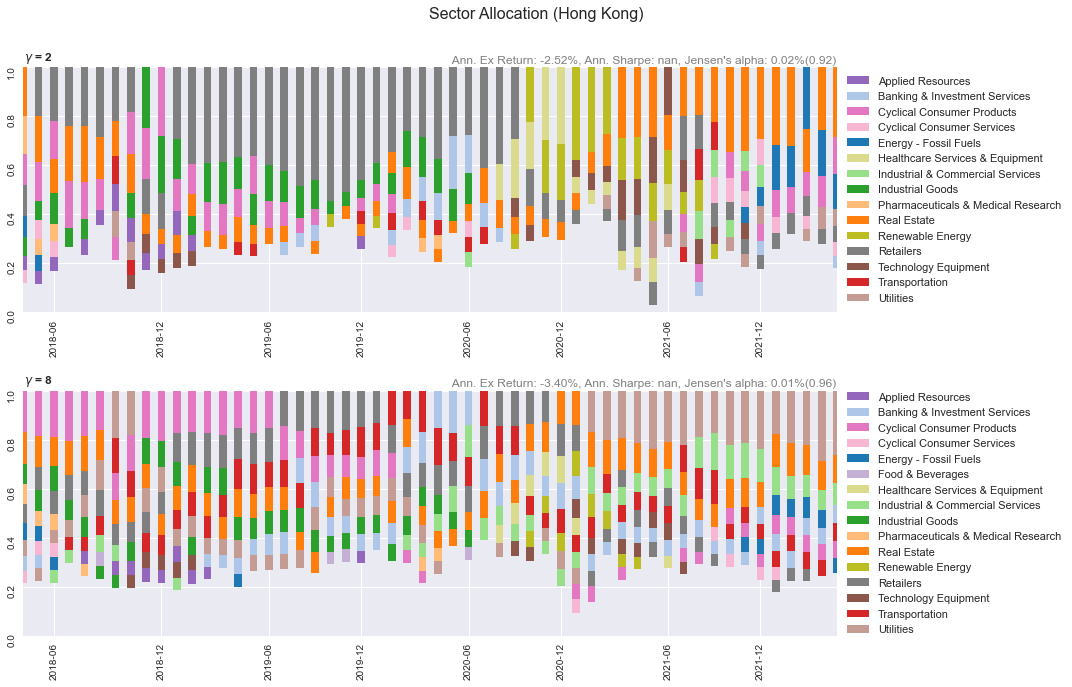

NOTE: figure not saved


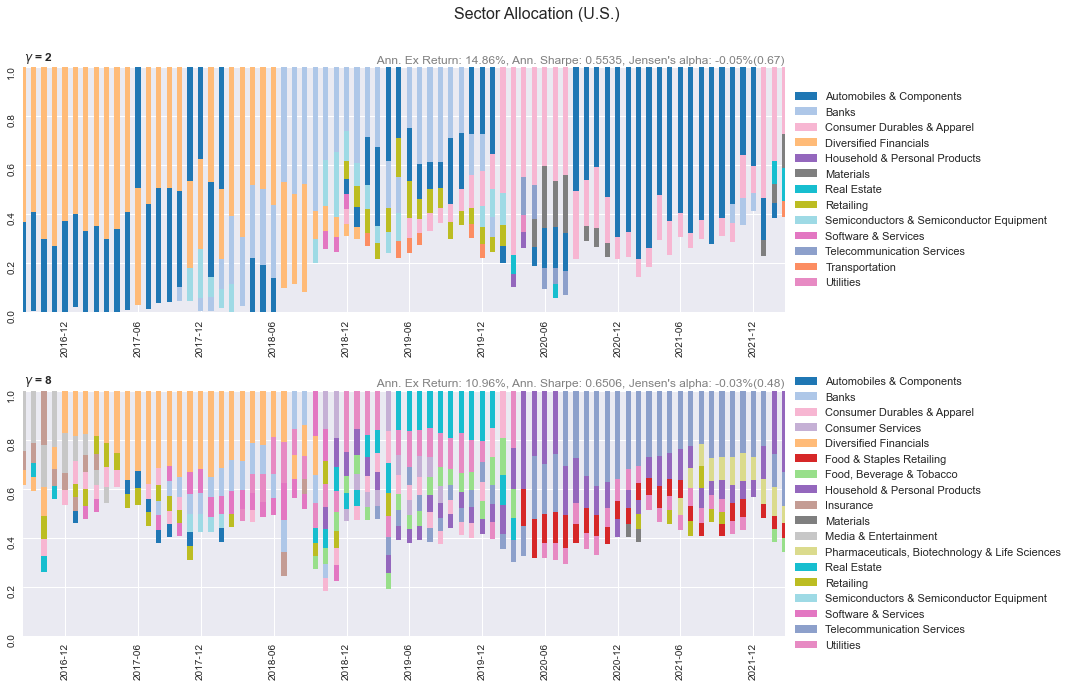

In [107]:
params = {'method':'factore',
         'values': [2, 8],
         'show_table': False,
         'save_fig': False}


for code in ['hk', 'us']:
    allocation_plot(code, 'industry_group', **params)

### CAPM (1 factor)



figure saved at .\plots\allocation_hk400_capm_weekly.png


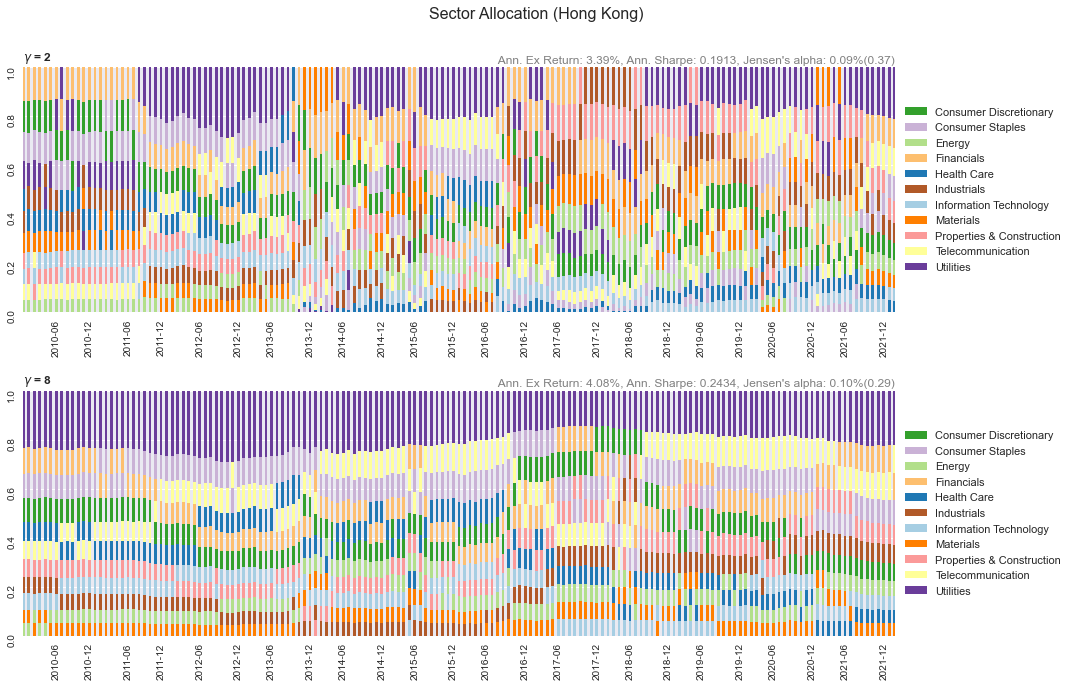

figure saved at .\plots\allocation_cn800_capm_weekly.png


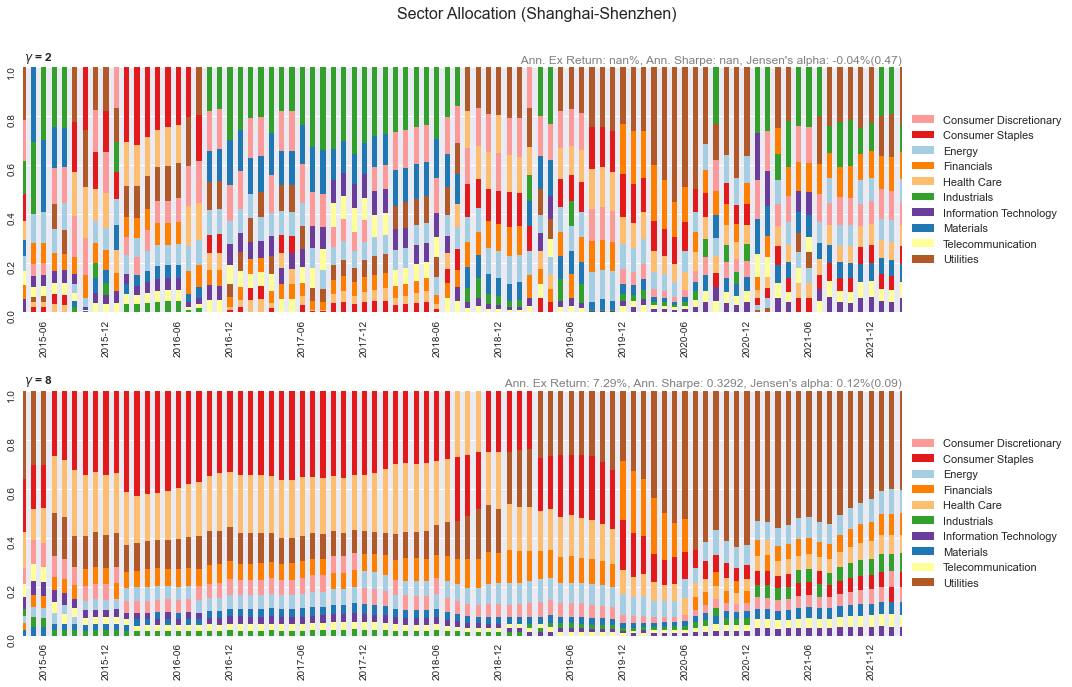

figure saved at .\plots\allocation_us1500_capm_weekly.png


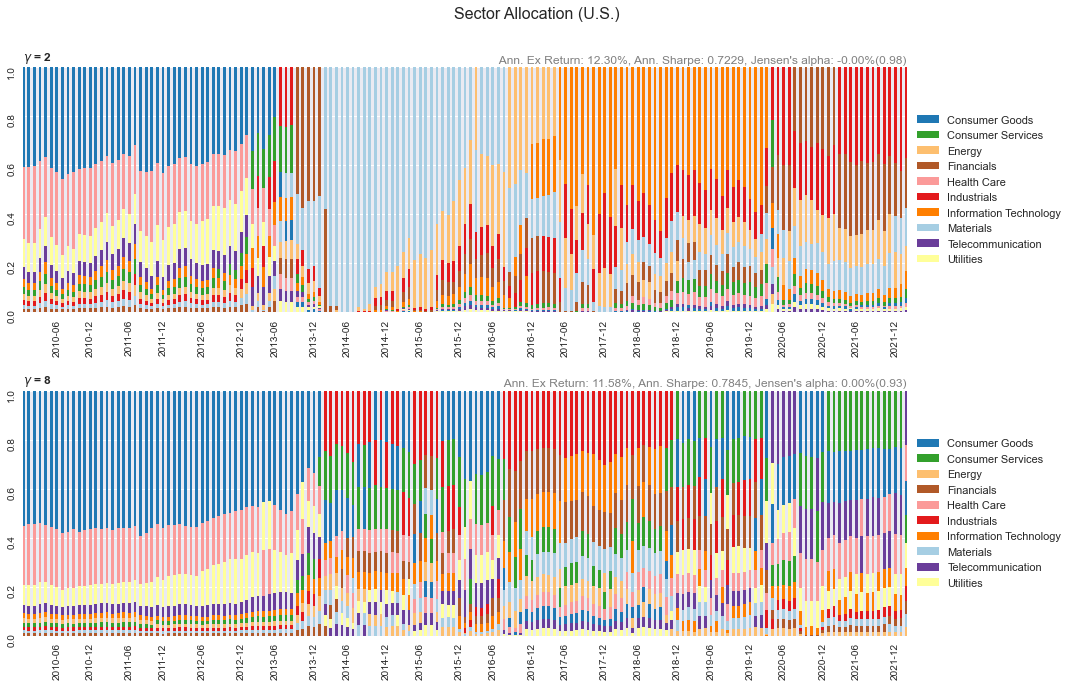

In [71]:
params = {'method':'capme',
         'values': [2, 8],
         'show_table': False,
         'save_fig': False}

for code in ['hk', 'cn', 'us']:
    allocation_plot(code, 'sector', **params)

### Historical

figure saved at .\plots\allocation_hk400_hist_weekly.png


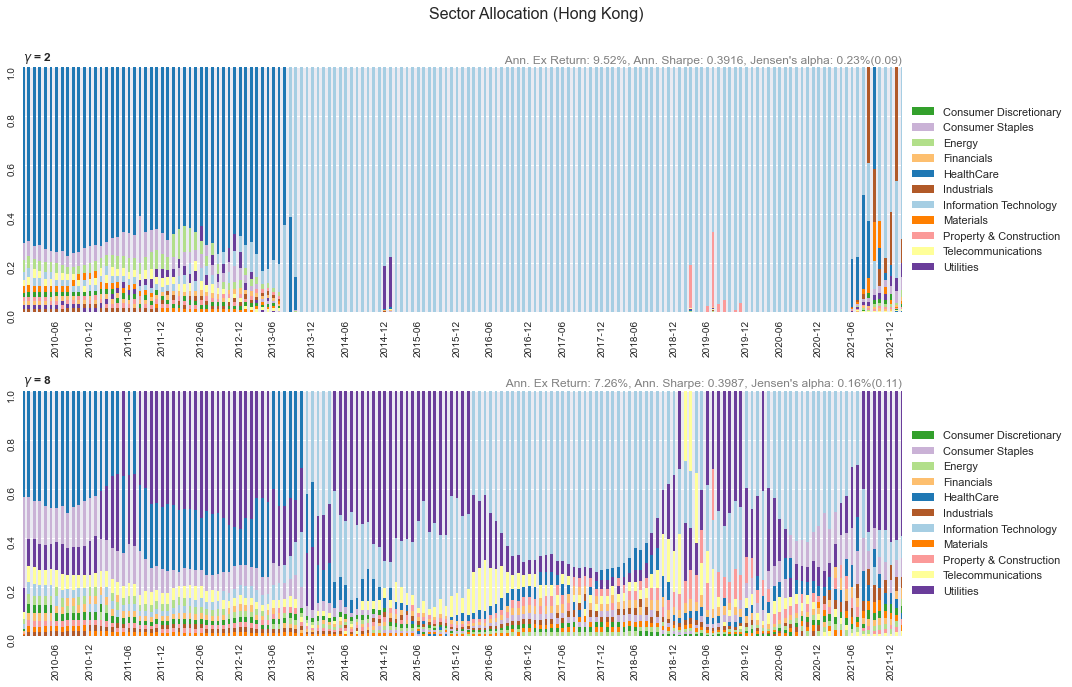

figure saved at .\plots\allocation_cn800_hist_weekly.png


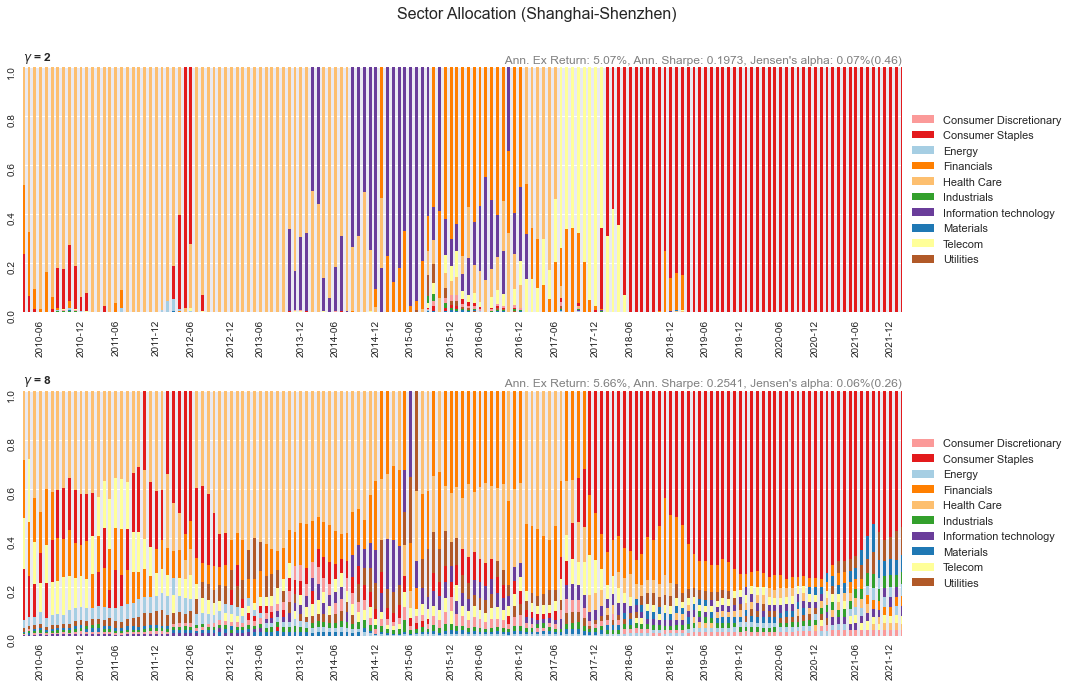

figure saved at .\plots\allocation_us1500_hist_weekly.png


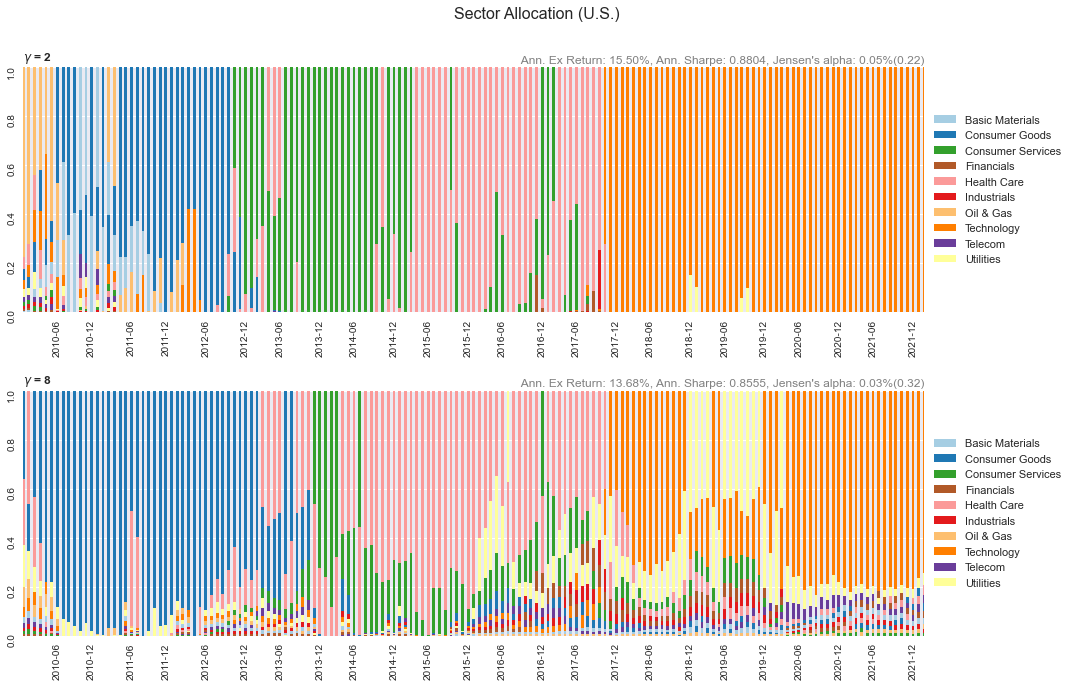

In [11]:
params = {'method':'histe',
         'values': [2, 8],
         'show_table': False,
         'save_fig': False}

for code in ['hk', 'cn', 'us']:
    allocation_plot(code, 'sector', **params)

### Factor Model (11 factors) - External Variable

NOTE: figure not saved


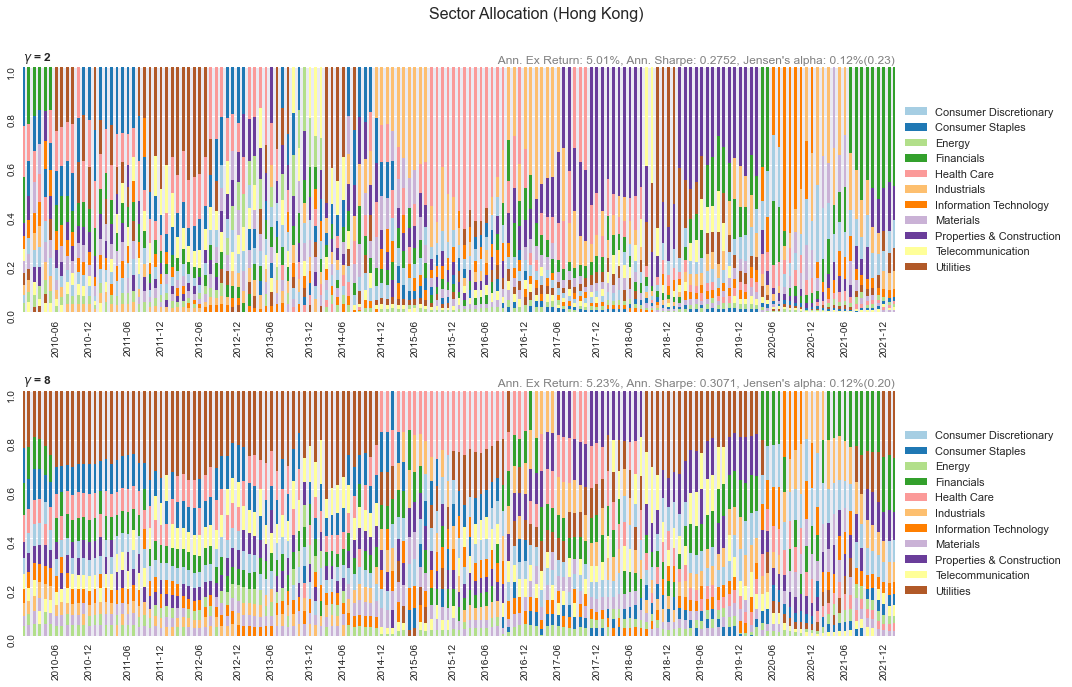

NOTE: figure not saved


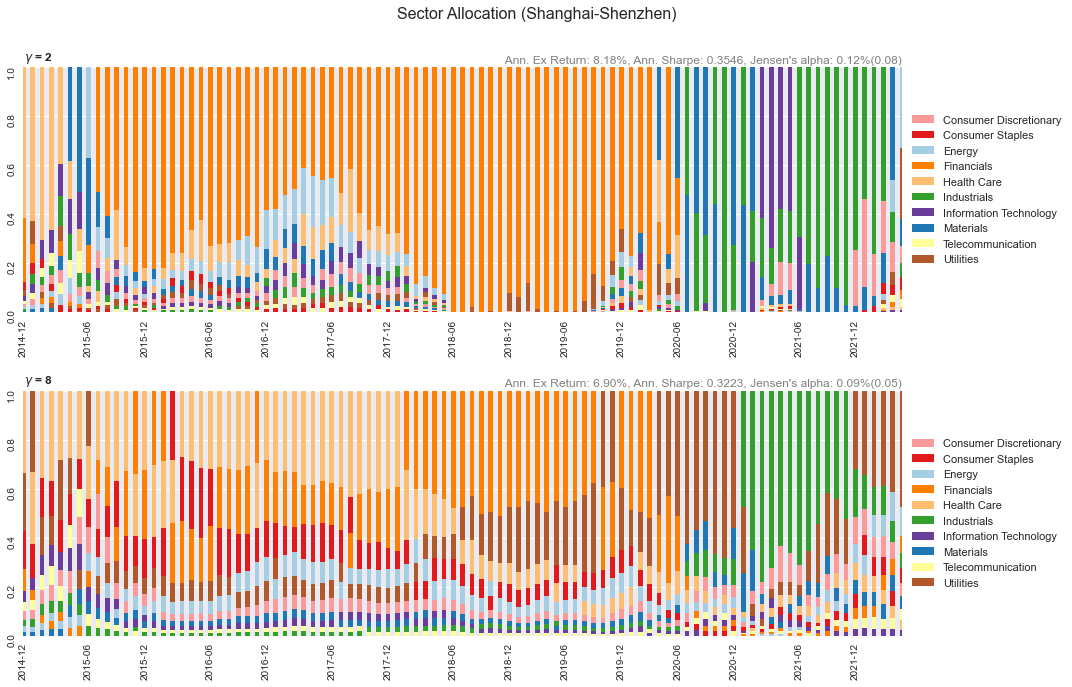

NOTE: figure not saved


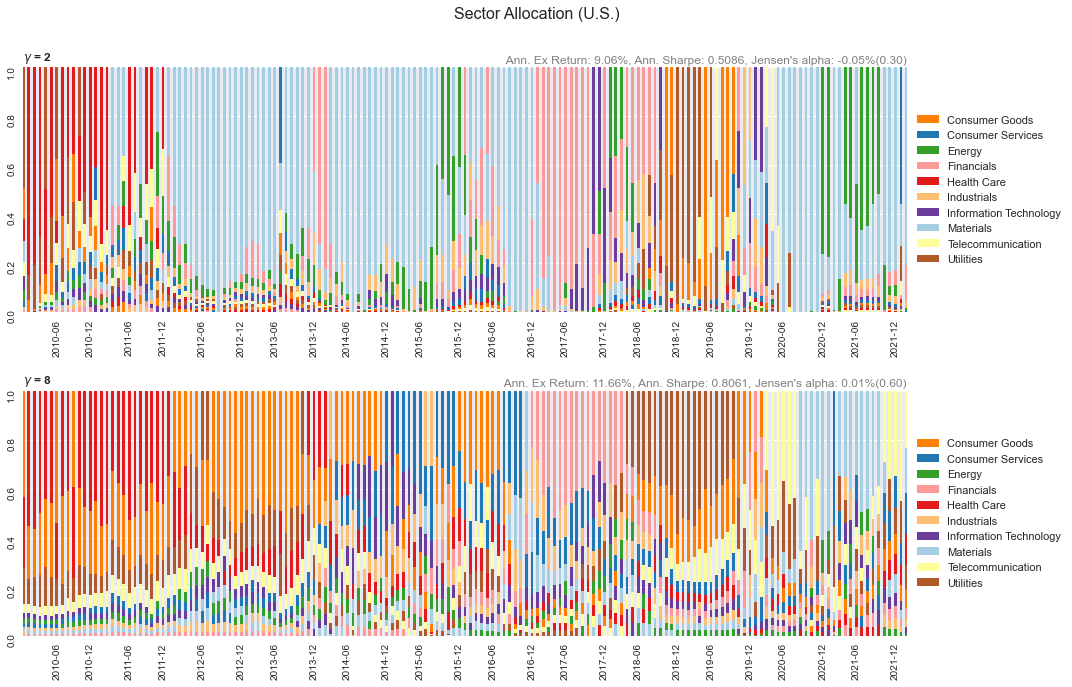

In [58]:
params = {'method':'factorxe',
         'values': [2, 8],
         'show_table': False,
         'save_fig': False}

for code in ['hk', 'cn', 'us']:
    allocation_plot(code, 'sector', **params)

### Comparison

NOTE: figure not saved


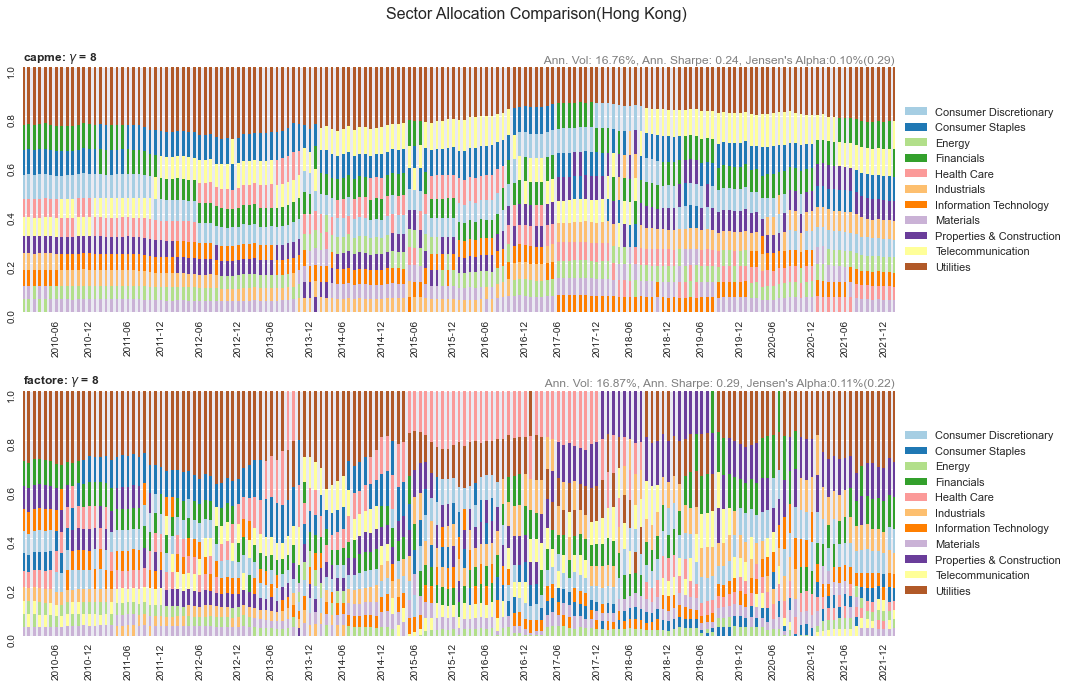

NOTE: figure not saved


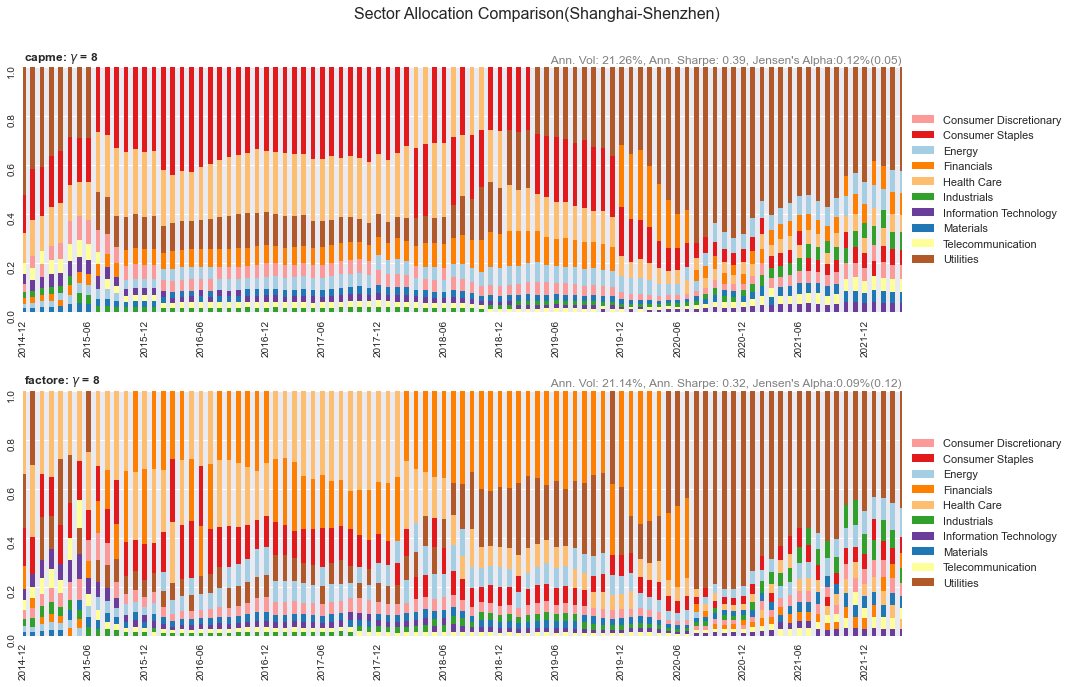

NOTE: figure not saved


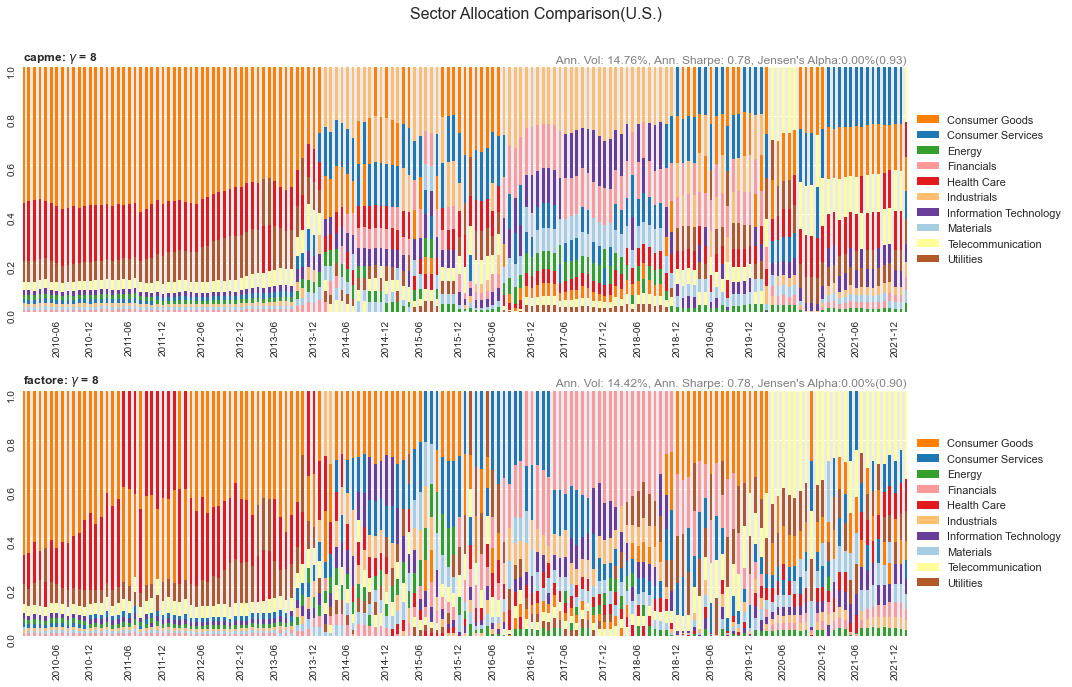

In [59]:
params = {'methods': ['capme','factore'],
         'value': 8,
         'save_fig': False}

for code in ['hk', 'cn', 'us']:
    comparison_plot(code,'sector', **params)

### Allocation changes
compute absolute weighting changes after each rebalancing

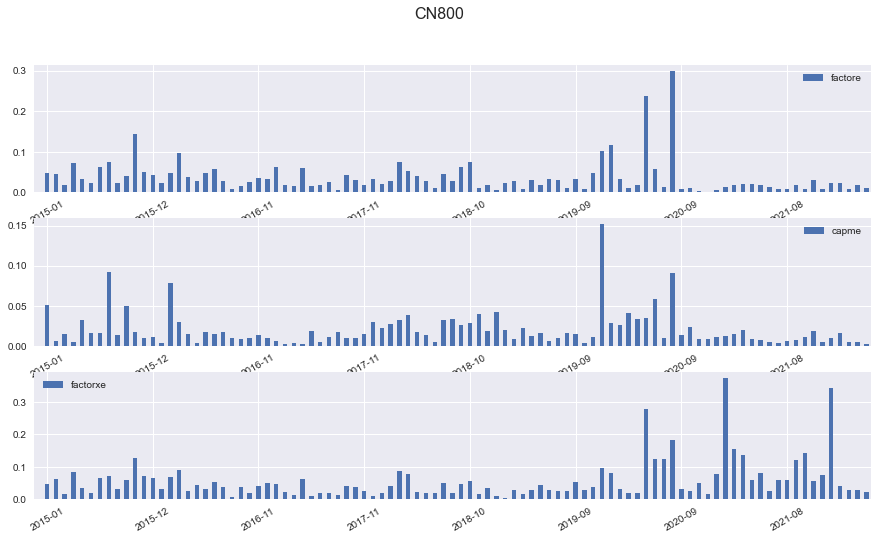

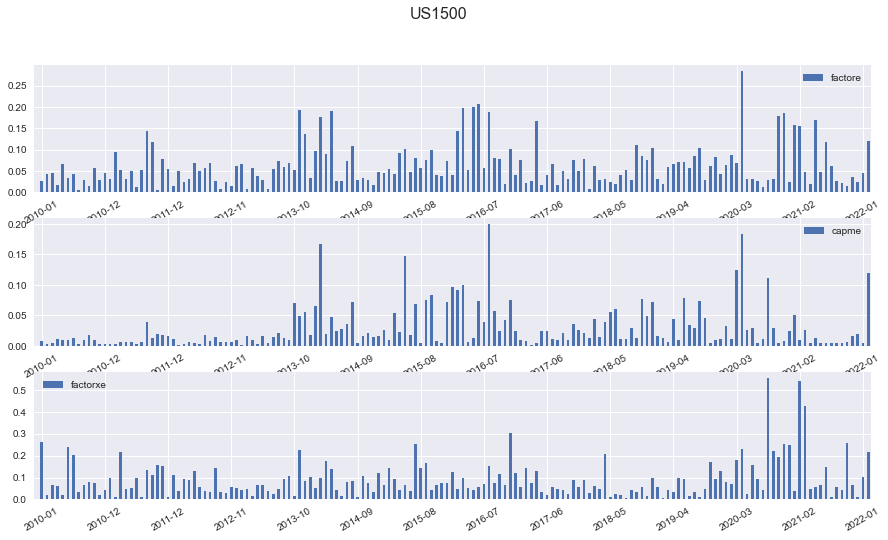

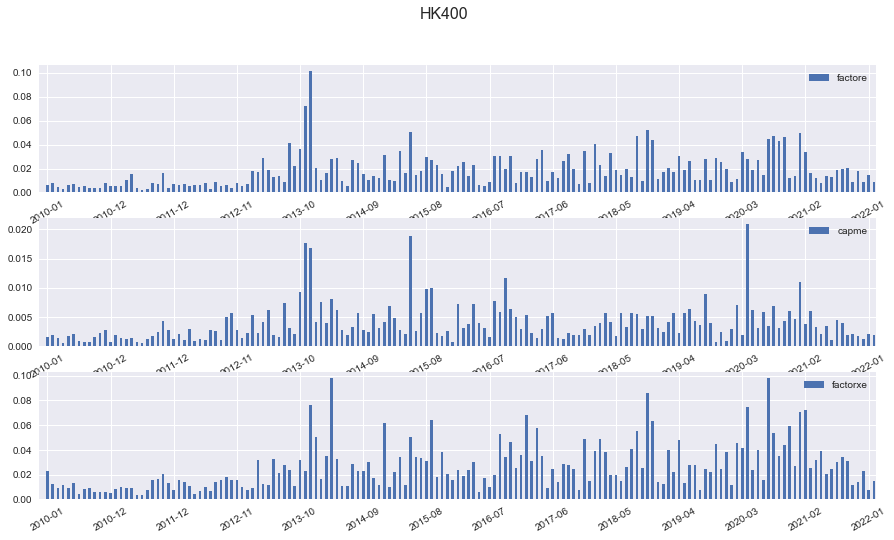

In [61]:
methods= ['factore','capme','factorxe']
for code in ["cn800", "us1500", "hk400"]:
    fig, axes = plt.subplots(figsize=(15, 8), nrows=len(methods))
    for i, method in enumerate(methods):
        weights = pd.read_csv(rf".\weights\{code[:2]}_sector_{method}.csv",index_col = 0)

        weights.index = pd.to_datetime(weights.index)
        _weights = weights.loc[(weights["gamma_op"] == 8)].iloc[::4,:len(weights.columns)-2]
        _weights.index = _weights.index.strftime("%Y-%m")
        _weights.diff(1).abs().max(axis=1).plot.bar(ax=axes[i], label=method,rot=30)
        axes[i].xaxis.set_major_locator(ticker.FixedLocator(np.arange(1, len(_weights.index),12)))
        axes[i].legend([method])
    fig.suptitle(code.upper(), size = 16) # set title of table

## Allocation - 3y

### Factor

figure saved at .\plots\allocation_hk400_factore3_weekly.png


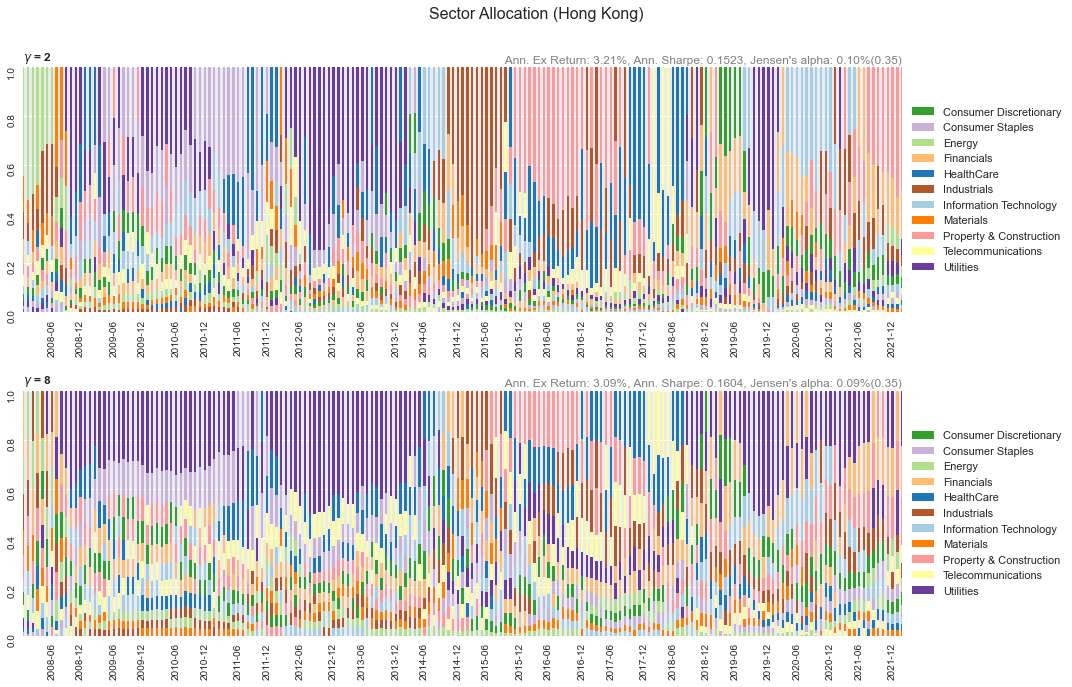

figure saved at .\plots\allocation_us1500_factore3_weekly.png


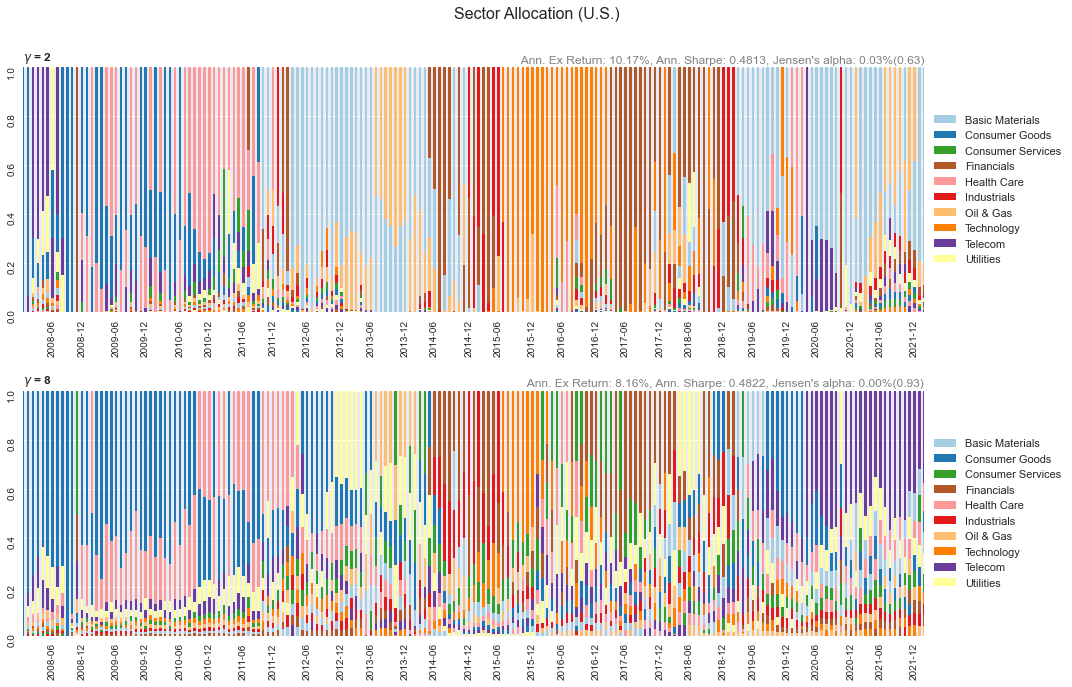

figure saved at .\plots\allocation_cn800_factore3_weekly.png


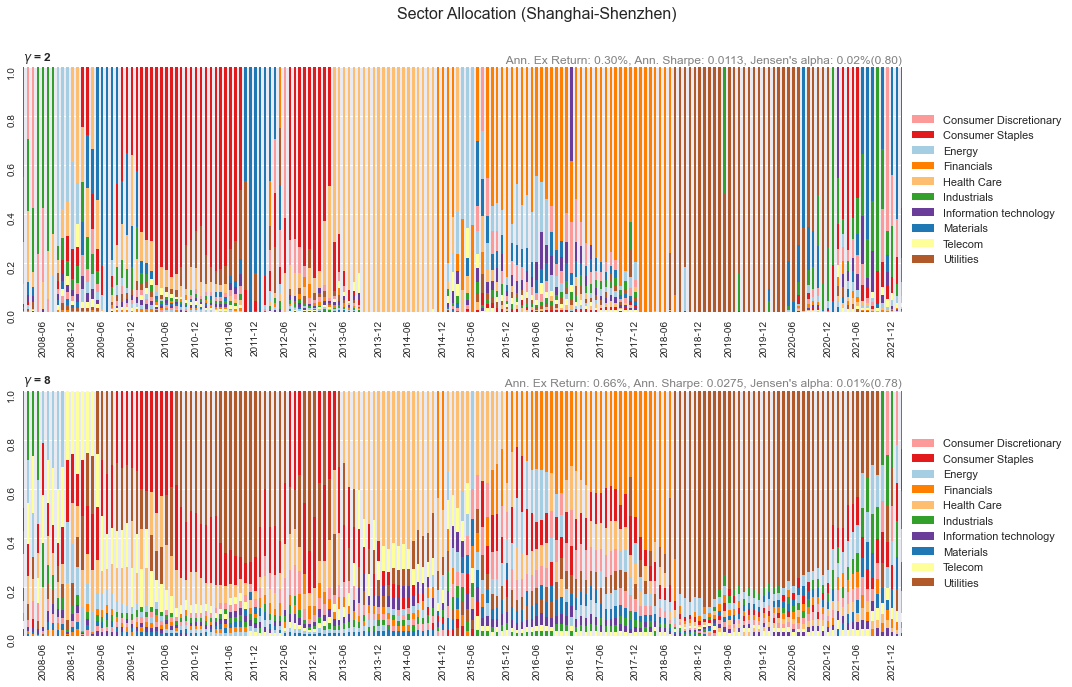

In [16]:
params = {'method':'quadprog_factore3',
         'name': 'gamma_op',
         'values': [2, 8],
         'b_weight': [1],
         'show_table': False}
allocation_plot(**code_list_week['hk'], **params)
allocation_plot(**code_list_week['us'], **params)
allocation_plot(**code_list_week['cn'], **params)

### CAPM

figure saved at .\plots\allocation_hk400_capme3_weekly.png


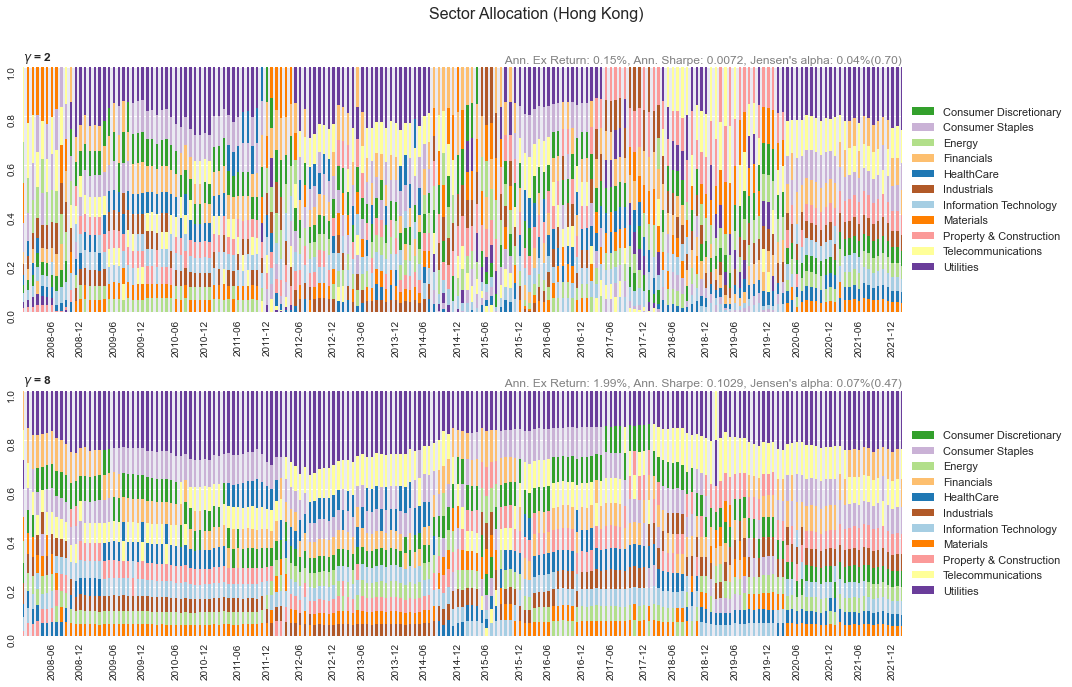

figure saved at .\plots\allocation_us1500_capme3_weekly.png


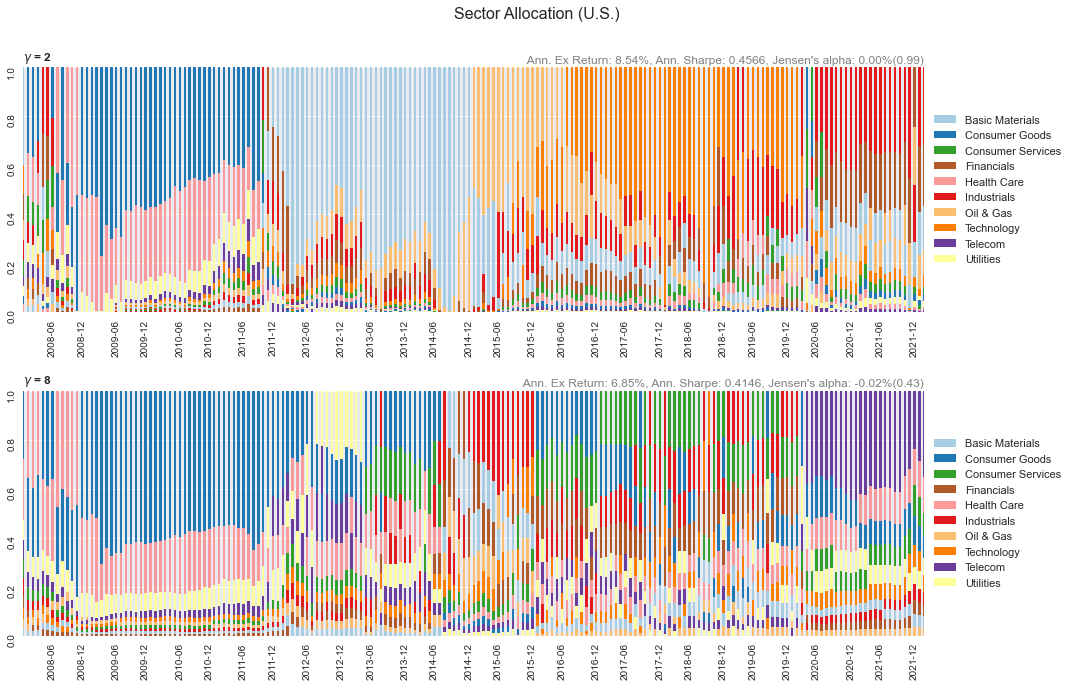

figure saved at .\plots\allocation_cn800_capme3_weekly.png


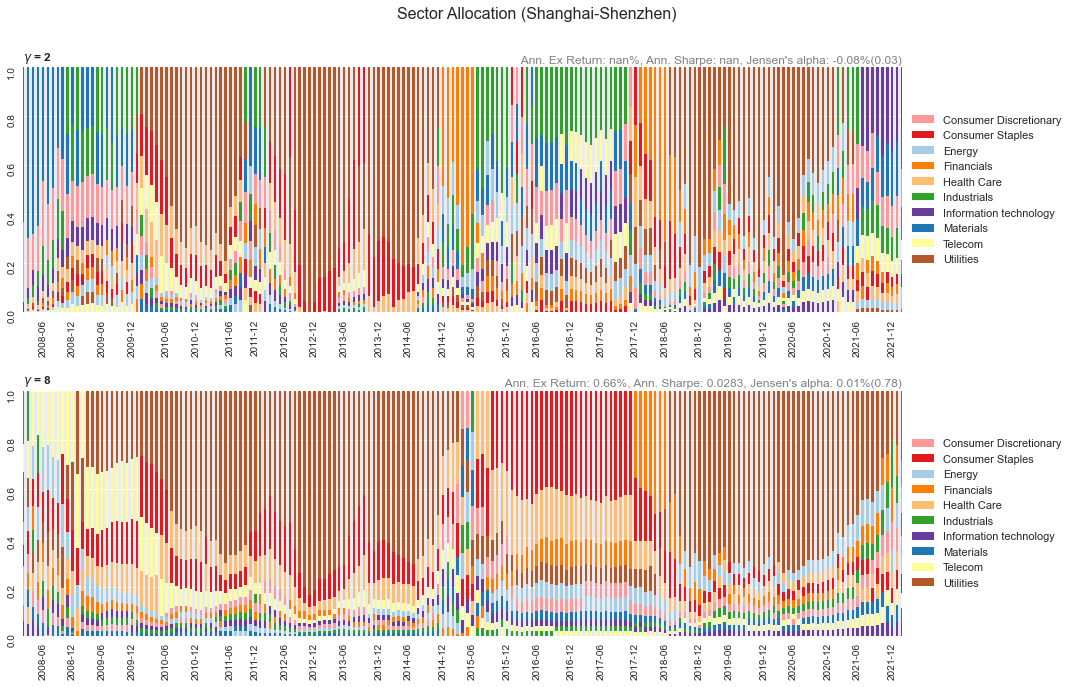

In [17]:
params = {'method':'quadprog_capme3',
         'name': 'gamma_op',
         'values': [2, 8],
         'b_weight': [1],
         'show_table': False}
allocation_plot(**code_list_week['hk'], **params)
allocation_plot(**code_list_week['us'], **params)
allocation_plot(**code_list_week['cn'], **params)

### Factor Model - External

figure saved at .\plots\allocation_hk400_factorxe3_weekly.png


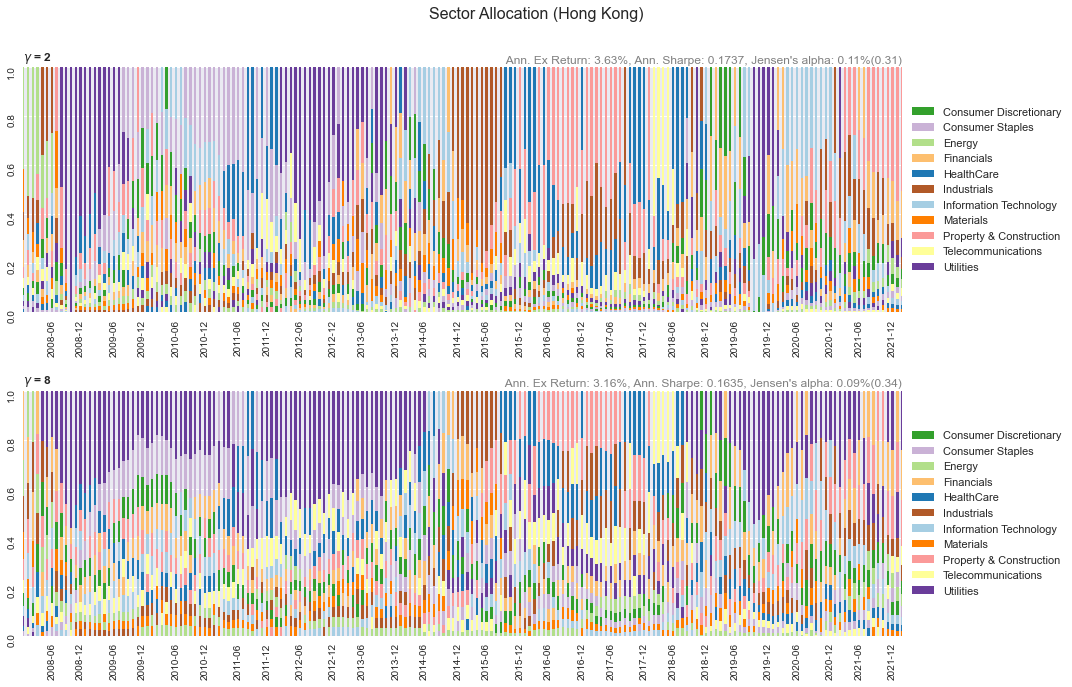

figure saved at .\plots\allocation_us1500_factorxe3_weekly.png


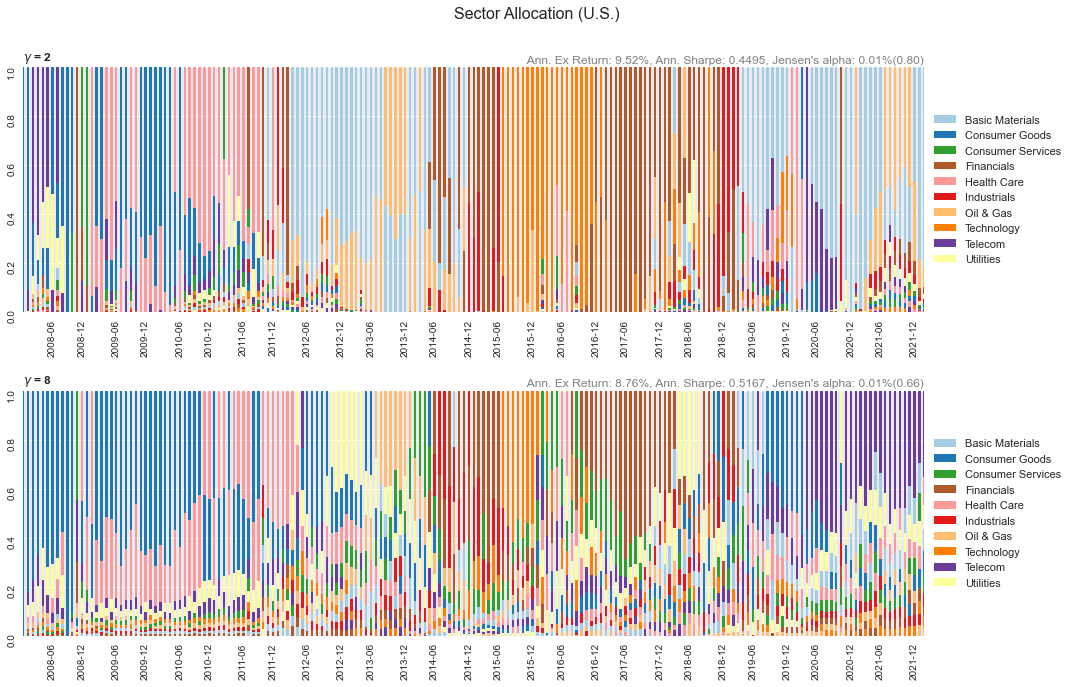

figure saved at .\plots\allocation_cn800_factorxe3_weekly.png


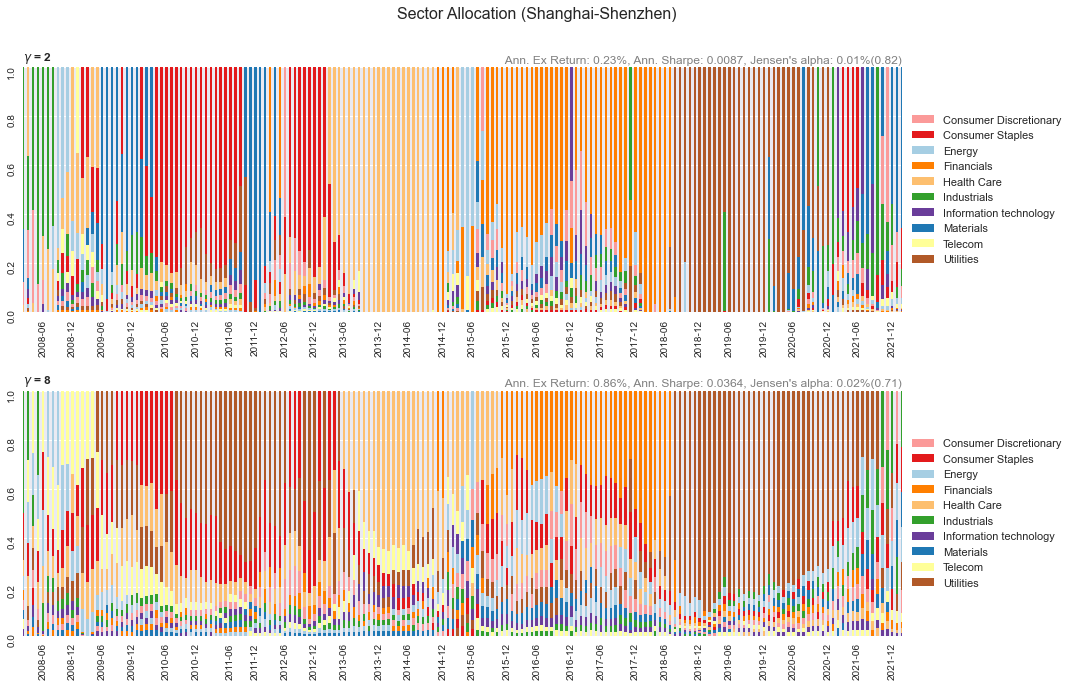

In [18]:
params = {'method':'quadprog_factorxe3',
         'name': 'gamma_op',
         'values': [2, 8],
         'b_weight': [1],
         'show_table': False}
allocation_plot(**code_list_week['hk'], **params)
allocation_plot(**code_list_week['us'], **params)
allocation_plot(**code_list_week['cn'], **params)

## Appendix
the codes below are not in use. Please ignore.

In [19]:
params = {'method':'formula_factore',
         'name': 'gamma_reg',
         'values': [0.005, 0.001],
         'b_weight': [1],
         'show_table': True}
allocation_plot(**code_list_week['hk'], **params)
allocation_plot(**code_list_week['cn'], **params)
# allocation_plot(**code_list['us'], **params)

for i, method in enumerate(methods):
        perf = cal_perf(code, method, useweekly, show_table = show_table)
        if not useweekly:
            weights = pd.read_csv(r".\weights\monthly\{}_{}.csv".format(code,method),index_col = 0)
        else:
            weights = pd.read_csv(r".\weights\weekly\{}_{}.csv".format(code,method),index_col = 0)
        method = method.split('_')[1]
        s1 = "{}: $\gamma$ = {}, w = {:.0%}".format(method, str(value), b_weight)
        _perf = perf.loc[('%.2f' %b_weight, "%.4f" %value)].to_list()
        s2 = "\n Ann. Vol: {2:.2%}, Ann. Sharpe: {3:.2f}, Jensen's Alpha:{4:.2%}({5:.2f})".format(*_perf)
        weights.index = pd.to_datetime(weights.index)
        _weights = weights.loc[(weights[name] == value)&(weights.b_weight == b_weight)].iloc[::4,:p]
        axes[i] = plot_one_weight_sorted(_weights, sectornames, 52 if useweekly else 12, s2, s1, axes[i], lag)


FileNotFoundError: [Errno 2] No such file or directory: '.\\performances\\weekly\\hk400_formula_factore.csv'

In [ ]:
weights = pd.read_csv(r".\weights\weekly\cn800_quadprog_factore.csv",index_col = 0)
weights.index = pd.to_datetime(weights.index)

_weights = weights.loc[(weights["gamma_op"] == 2)&(weights.b_weight == 1)].iloc[::4,:10]

import matplotlib
cmap = matplotlib.cm.get_cmap('Paired')
_weights.columns = code_list_week['cn']['sectornames'] #sectorsnmae 
_weight = pd.DataFrame(_weights.stack())
_weight.index.names = ("date", "sector")
_weight.columns = ['w']
_weight.reset_index()
_weight.sort_values('w', ascending=False, inplace=True)
_weight = _weight.groupby("date").apply(ranker)
_weight.sort_values(['date','rank'], ascending=[True, False], inplace=True)
_weight.reset_index(inplace = True)
_weight['col']=_weight.apply(color_assigment, axis=1)
_weight['bottoms']= _weight.groupby("date")['w'].cumsum() - _weight['w']
_weight['date'] = _weight['date'].astype(str)
fig, ax = plt.subplots(figsize=(12,5))
for i in range(len(_weight["date"])):
    ax.bar(_weight["date"][i],_weight['w'][i], width=0.5, color=_weight['col'][i],bottom=_weight['bottoms'][i], label=_weight['sector'][i])

plt.xticks(rotation=90)

#format legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

dates = pd.Series(_weight.date.unique())
# np.where((dates.str[5:7].isin(['06','12']))&(~dates.shift(1).str[5:7].isin(['06','12'])))
axis_loc = np.where((dates.str[5:7].isin(['06','12']))&(~dates.shift(1).str[5:7].isin(['06','12'])))
plt.gca().xaxis.set_major_locator(ticker.FixedLocator(locs=list(axis_loc[0])))

In [ ]:
# NOT IN USE - ARCHIVE
def single_plot(sector_index, sectornames, country, code, method, param_name, param_value, b = 1, window=60, lag = 9):
    df_sectors, p, T = load_data(sector_index, code)
    plt.style.use('seaborn')
    if param_name == 'gamma_op':
        values = [2, 4, 8]
    else:
        values = [0.01, 0.05, 0.001]
    perf = cal_perf(code, method, show_table = True)
    fig, axes = plt.subplots(figsize=(20, 6), ncols=1, nrows = 1)
    weights = pd.read_csv(r".\weights\monthly\{}_{}.csv".format(code,method),index_col = 0)
    _weights = weights.loc[(weights[param_name] == param_value)&(weights.b_weight == b)].iloc[:,:p]

    s1 = "{} = {}, w = {:.0%}\n \n".format(param_name, str(param_value), b)
    _perf = perf.loc[('%.2f' %b, "%.4f" %param_value)].to_list()
    s2 = "Cum. Return: {0:.2%} Ann. Ex Return: {1:.2%}\n Ann. Vol: {2:.2%} Ann. Sharpe: {3:.4f}".format(*_perf)

    axes = plot_one_weight(_weights, s1+s2, axes, lag)
    
    fig.suptitle("Sector Allocation ({})".format(country), fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])
    
    plt.show()